In [245]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

ModuleNotFoundError: No module named 'mediapipe'

In [244]:
!pip install mediapipe

  Using cached mediapipe-0.10.14-cp39-cp39-win_amd64.whl (50.8 MB)
  Using cached jax-0.4.30-py3-none-any.whl (2.0 MB)
  Using cached sounddevice-0.5.1-py3-none-win_amd64.whl (363 kB)
  Using cached attrs-24.2.0-py3-none-any.whl (63 kB)
  Using cached jaxlib-0.4.30-cp39-cp39-win_amd64.whl (51.9 MB)
  Using cached opencv_contrib_python-4.10.0.84-cp37-abi3-win_amd64.whl (45.5 MB)
  Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
  Using cached cffi-1.17.1-cp39-cp39-win_amd64.whl (181 kB)
  Using cached ml_dtypes-0.5.0-cp39-cp39-win_amd64.whl (211 kB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\dev\\skin_condition_detector\\venv\\Lib\\site-packages\\cv2\\cv2.pyd'
Check the permissions.

You should consider upgrading via the 'C:\dev\skin_condition_detector\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [230]:
def convert_BGR2RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [231]:
def detect_faces(f_cascade, colored_img, scaleFactor=1.1, minNeighbors=5):
    img_copy = np.copy(colored_img)
    gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    print("Detecting faces...")
    faces = f_cascade.detectMultiScale(gray, scaleFactor=scaleFactor, minNeighbors=minNeighbors)
    if len(faces) == 0:
        print("No faces detected.")
        return img_copy, []
    print(f"Number of faces detected: {len(faces)}")
    
    cropped_faces = []
    for (x, y, w, h) in faces:
        cv2.rectangle(img_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cropped_face = img_copy[y:y+h, x:x+w]
        cropped_faces.append(cropped_face)
    
    return img_copy, cropped_faces

def enhance_contrast(image):
    print("Applying HDR effect...")
    if len(image.shape) != 3 or image.shape[2] != 3:
        print("Error: Input image is not in the correct format. Expected a BGR image.")
        return image
    
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    l = cv2.equalizeHist(l)
    
    clahe = cv2.createCLAHE(clipLimit=1.7, tileGridSize=(10, 10))
    l = clahe.apply(l)
    
    lab = cv2.merge((l, a, b))
    enhanced_image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    
    enhanced_image = cv2.convertScaleAbs(enhanced_image, alpha=1.3, beta=-50)
    
    return enhanced_image

def highlight_skin_issues(face_img):
    print("Highlighting skin issues...")
    enhanced_img = enhance_contrast(face_img)
    gray_img = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2GRAY)
    
    edges = cv2.Canny(gray_img, 100, 200)
    
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)
    results = face_mesh.process(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            points = [(int(pt.x * face_img.shape[1]), int(pt.y * face_img.shape[0])) for pt in face_landmarks.landmark]
            hull = cv2.convexHull(np.array(points))
            cv2.drawContours(edges, [hull], -1, 0, thickness=cv2.FILLED)
            
            # Исключаем области глаз, бровей, губ
            for i in [33, 263, 61, 291, 199, 10, 109, 338, 297, 332, 284, 54, 67]:
                landmark = points[i]
                cv2.circle(edges, landmark, 10, 0, thickness=cv2.FILLED)
    
    min_area = 1e-5 * face_img.shape[0] * face_img.shape[1]
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Number of potential skin issues detected: {len(contours)}")
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w * h > min_area: 
            cv2.drawContours(face_img, [contour], -1, (0, 0, 255), thickness=cv2.FILLED)
            overlay = face_img.copy()
            cv2.drawContours(overlay, [contour], -1, (0, 0, 255), thickness=cv2.FILLED + 30)
            cv2.addWeighted(overlay, 0.1, face_img, 0.9, 0, face_img)
    
    print("Skin issues highlighted successfully.")
    return face_img

def process_image(image_path, minNeighbors=5):
    print(f"Processing image: {image_path}")
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Image not found.")
        return None, []
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    img_with_faces, cropped_faces = detect_faces(face_cascade, img, minNeighbors=minNeighbors)
    
    processed_faces = []
    for idx, face in enumerate(cropped_faces):
        print(f"Processing face {idx+1}...")
        processed_face = highlight_skin_issues(face)
        processed_faces.append(processed_face)
    
    print("Image processing completed.")
    return img_with_faces, processed_faces


## Usage example

Processing image: acne.png
Detecting faces...
No faces detected.
Image processing completed.


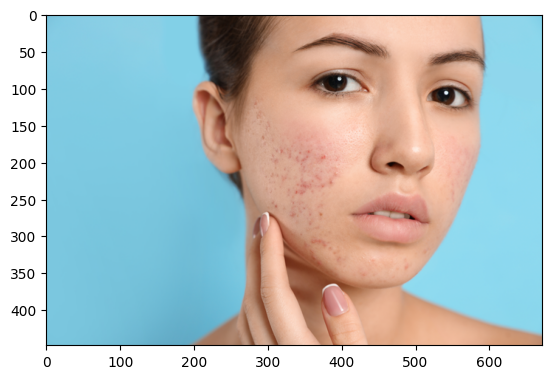

In [232]:
input_image_path = "image.png"
img_with_faces, processed_faces = process_image(input_image_path, minNeighbors=5)

if img_with_faces is not None:
    display(plt.imshow(convert_BGR2RGB(img_with_faces), ))

## Step by step demonstration

#### Input image

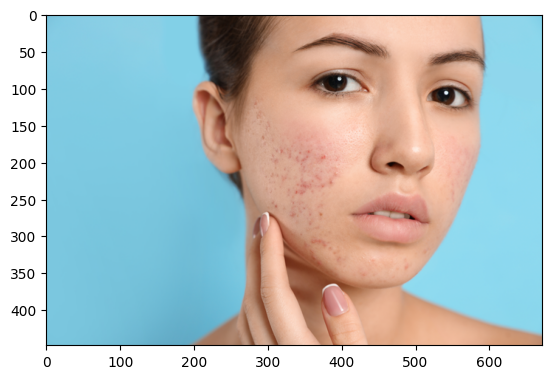

In [233]:
input_image_path = "acne.png"
input_image = cv2.imread(input_image_path)
display(plt.imshow(convert_BGR2RGB(input_image)))

#### Contrast enhancing

Applying HDR effect...


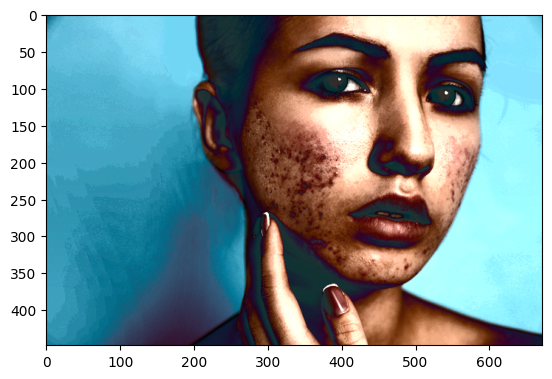

In [234]:
enhanced_contr_image = enhance_contrast(input_image)
display(plt.imshow(convert_BGR2RGB(enhanced_contr_image)))
